# Generative Model

In [22]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

# Simulating Data from an rSLDS

Below, we create a simulated dataset from a non-linear system, which we'll call the "Nascar" dataset. The Nascar dataset is meant to emulate cars going around a track. There are 4 states total: 2 each for driving along each straightaway, and two for semicircular turns at each end of the track.

You'll note that in creating the rSLDS we use transitions="recurrent_only". This means that the transition probabilities are determined only by the previous state (and on the inputs, if present). There is no dependence on the prior 
. Instead, each state simply has a constant bias 
 which biases the transitions toward state . This model is strictly less flexible that the full rSLDS formulation. By setting the weights on the current state to be very large, we make the discrete state transitions essentially deterministic. After creating the rSLDS and sampling a trajectory, we plot the true trajectory below.

In [23]:
# # very simple sim params
# T = 10000
# K = 2 # 2 states
# D_obs = 3 # 3 dim input 
# D_latent = 2 # 2 dim latent

In [24]:
# # Simulate very simply data
# def make_simple_model():
    
#     # init As and bs (latent transition matrices - one of each for every state)
#     As = []
#     bs = []
#     As = [random_rotation(D_latent, np.pi/24.)]

#     # Set the center points for each system
#     centers = [np.array([+2.0, 0.])]
#     bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

#     # Add first state
#     As.append(np.eye(D_latent))
#     bs.append(np.array([+0.1, 0.]))

#     # Add second state
#     #As.append(np.array([[2, 1], [3, 1]]))
#     #bs.append(np.array([-1.5, 0.]))

#     # Construct multinomial regression to divvy up the space
#     w1, b1 = np.array([+1.0, -1.0]), np.array([-2.0])   # x + b > 0 -> x > -b
#     w2, b2 = np.array([-1.0, 1.0]), np.array([2.0])   # -x + b > 0 -> x < b
#     #w3, b3 = np.array([-1.0, 0.0]), np.array([-.0])

#     Rs = np.row_stack((10*w1, 10*w2))#, 100*w3))
#     r = np.concatenate((10*b1, 10*b2))#, 100*b3))
    
#     true_rslds = ssm.SLDS(D_obs, K, D_latent, 
#                       transitions="recurrent_only",
#                       dynamics="diagonal_gaussian",
#                       emissions="gaussian_orthog",
#                       single_subspace=True)
    
    
#     true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
#     true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    
#     true_rslds.dynamics.As = np.array(As)
#     true_rslds.dynamics.bs = np.array(bs)
    
#     true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    
#     true_rslds.transitions.Rs = Rs
#     true_rslds.transitions.r = r
    
#     true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
#     return true_rslds

# # Sample from the model
# true_rslds = make_simple_model()
# z, x, y = true_rslds.sample(T=T)

In [25]:
# fig = plt.figure(figsize=(15, 6)) 
# gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
# ax0 = plt.subplot(gs[0])
# plot_trajectory(z, x, ax=ax0)
# plt.title("True Trajectory")

# ax1 = plt.subplot(gs[1])
# plot_observations(z[:1000], y[:1000,:3], ax=ax1)
# plt.title("Observations for first 1000 time steps")
# plt.tight_layout()

In [26]:
# Global parameters
T = 10000
K = 4
D_obs = 10
D_latent = 2

In [27]:
# Simulate the "nascar" data
def make_nascar_model():
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))
    
    true_rslds = ssm.SLDS(D_obs, K, D_latent, 
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    
    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r
    
    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds

# Sample from the model
true_rslds = make_nascar_model()
z, x, y = true_rslds.sample(T=T)

In [35]:
#p z
print(true_rslds.dynamics.As, true_rslds.dynamics.As.shape)
print(true_rslds.dynamics.bs, true_rslds.dynamics.bs.shape)

[[[ 0.99144486  0.13052619]
  [-0.13052619  0.99144486]]

 [[ 0.99785892  0.06540313]
  [-0.06540313  0.99785892]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]] (4, 2, 2)
[[ 0.01711028  0.26105238]
 [-0.00428215 -0.13080626]
 [ 0.1         0.        ]
 [-0.25        0.        ]] (4, 2)


In [36]:
print(true_rslds.transitions.Rs, true_rslds.transitions.Rs.shape)
print(true_rslds.transitions.r, true_rslds.transitions.r.shape)

[[ 100.    0.]
 [-100.    0.]
 [   0.   10.]
 [   0.  -10.]] (4, 2)
[-200. -200.    0.    0.] (4,)


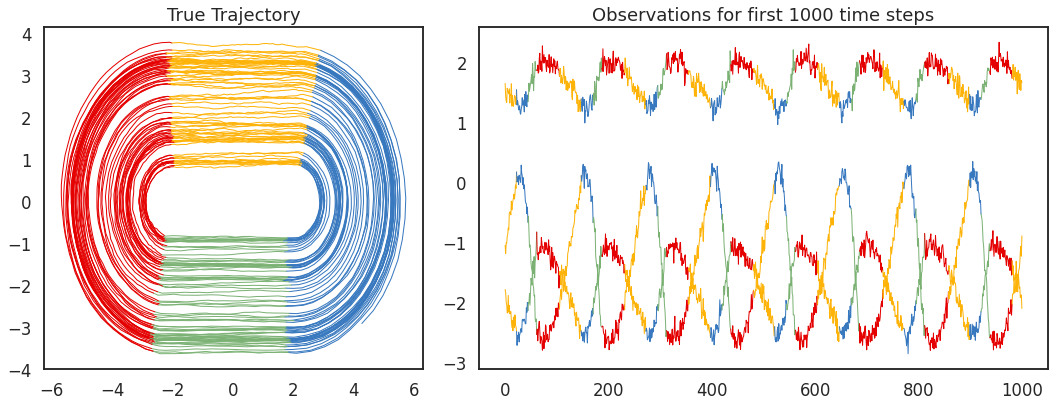

In [28]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(z, x, ax=ax0)
plt.title("True Trajectory")

ax1 = plt.subplot(gs[1])
plot_observations(z[:1000], y[:1000,:3], ax=ax1)
plt.title("Observations for first 1000 time steps")
plt.tight_layout()

In [29]:
print('x: ', x.shape) # latent variables
print('z: ', z.shape) # discrete state labels (K=4)
print('y: ', y.shape) # observed data

x:  (10000, 2)
z:  (10000,)
y:  (10000, 10)


In [18]:
print(z)
new_z = np.zeros((T, K+1))
for r, row in enumerate(new_z):
    row[z[r]+1] = 1
print(new_z, new_z.shape)

[2 2 2 ... 0 0 0]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]] (10000, 5)


In [19]:
import pandas as pd
z_df = pd.DataFrame(new_z).astype('int32')
z_df.columns = ['empty', 'right', 'left', 'top', 'bottom']

In [20]:
z_df.head()

,empty,right,left,top,bottom
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [21]:
z_df.to_csv('/home/bsb2144/daart/daart_utils/data/ssm/labels-hand/ssm_v1_labels.csv')

In [22]:
print(y)

[[-1.04499563 -1.77877845  1.65514274 ... -0.24330994 -0.12664664
  -0.04589111]
 [-1.17803416 -1.83263971  1.44051952 ... -0.37755368 -0.40049092
  -0.19657277]
 [-1.00159819 -1.98798632  1.35832326 ... -0.67846975 -0.37755159
  -0.15995416]
 ...
 [ 0.66802552 -2.73858446  0.94459856 ... -2.99672229  1.47924431
   0.95414221]
 [ 0.48487455 -2.57163007  1.14205709 ... -2.91600963  1.36063007
   0.92788862]
 [ 0.21348793 -2.33196392  1.20761315 ... -2.74220844  1.15015707
   1.22540791]]


In [30]:
import h5py
filename = "/home/bsb2144/daart/daart_utils/data/fly/markers/2019_06_26_fly2_labeled.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])
    #Checkout what keys are inside that group.
    for key in data:
        dd = f[a_group_key][()]
        print(dd)

    

Keys: <KeysViewHDF5 ['df_with_missing']>
<class 'h5py._hl.group.Group'>


AttributeError: 'tuple' object has no attribute 'encode'

In [31]:
df_test = pd.read_hdf(filename)

In [32]:
df_test.head()

scorer    model-params_ws=0.0e+00_wt=0.0e+00_s0=100_fit-resnet_meta-iter=3.ckpt-0  \
bodyparts                                                             abdomen-top   
coords                                                                          x   
0                                                  46.566341                        
1                                                  46.970222                        
2                                                  47.679111                        
3                                                  47.901737                        
4                                                  47.698414                        

scorer                                                               \
bodyparts                        addomen-bot                          
coords              y likelihood           x           y likelihood   
0          132.622192        0.5   69.967567  166.289642        0.5   
1          132.949753        0.5   71.707909  167.003738        0.5   
2          132.827347        0.5   72.944328  167.533096        0.5   
3          133.724747        0.5   73.286430  167.252991        0.5   
4          133.288605        0.5   72.978325  166.555252        0.5   

scorer                                                  ...             \
bodyparts   hind-top                          hind-bot  ...    mid-top   
coords             x           y likelihood          x  ... likelihood   
0          84.996941  123.611755        0.5  69.317078  ...        0.5   
1          84.896645  123.741203        0.5  68.587982  ...        0.5   
2          84.361206  123.366608        0.5  68.753296  ...        0.5   
3          83.859879  122.888275        0.5  68.842331  ...        0.5   
4          82.954094  123.825729        0.5  68.655357  ...        0.5   

scorer                                                               \
bodyparts     mid-bot                           fore-top              
coords              x           y likelihood           x          y   
0          141.163895  111.921829        0.5  218.274734  71.578621   
1          141.335083  112.526123        0.5  218.547012  71.686684   
2          141.517059  112.356468        0.5  218.254227  71.876541   
3          141.609314  111.899658        0.5  216.532303  71.335945   
4          141.608200  111.858795        0.5  216.910416  71.252472   

scorer                                                  
bodyparts               fore-bot                        
coords    likelihood           x          y likelihood  
0                0.5  244.814163  98.714684        0.5  
1                0.5  244.612701  99.209396        0.5  
2                0.5  244.182922  98.740295        0.5  
3                0.5  244.231522  98.943741        0.5  
4                0.5  244.117935  97.948608        0.5  

[5 rows x 24 columns]

In [36]:
# save y (data) as numpy to markers file
markers_path = '/home/bsb2144/daart/daart_utils/data/ssm/markers/ssm_v1_labeled.npy'

In [37]:
np.save(markers_path, y)